In [58]:
# Import, pre-processing and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
# Modeling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge

In [2]:
os.getcwd()

'D:\\Others\\Interview task AbInBev'

In [3]:
df1 = pd.read_csv('train_v9rqX0R.csv')
df1.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
df1.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [6]:
#df1[df1.isna().any(axis=1)]
df1['Item_Weight'] = df1['Item_Weight'].fillna(df1.groupby('Item_Identifier')['Item_Weight'].transform('mean'))
df1[df1['Item_Weight'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [7]:
df1.isna().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [8]:
# User defined function for imputing missing weight with mean weight of SKUs with similar traits 
def impute_weight_traits(df,weight,traits):
    missing_df = df[df[weight].isnull()]
    grouped_means = df.groupby(traits)[weight].agg('mean')
    
    def impute_weight(row):
        if pd.isnull(row[weight]):
            group = tuple(row[traits].values)
            return grouped_means[group]
        else:
            return row[weight]
    df[weight] = df.apply(impute_weight,axis=1)
    
    return df

In [9]:
df2 = impute_weight_traits(df1,weight='Item_Weight',traits=['Item_Fat_Content','Item_Type'])

In [10]:
df2[df2['Item_Weight'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [11]:
df2[df2['Item_Weight']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [12]:
df2['Item_Weight'].apply(type).value_counts()

<class 'float'>    8523
Name: Item_Weight, dtype: int64

In [13]:
# User defined function for imputing missing size with mean size of stores with similar traits. 
def impute_size_traits(df,size,traits):
    missing_df = df[df[size].isnull()]
    grouped_means = df.groupby(traits)[size].agg(pd.Series.mode)
    
    def impute_size(row):
        if pd.isnull(row[size]):
            group = tuple(row[traits].values)
            return grouped_means[group]
        else:
            return row[size]
    df[size] = df.apply(impute_size,axis=1)
    
    return df

In [14]:
df2 = impute_size_traits(df2,size='Outlet_Size',traits=['Outlet_Location_Type','Outlet_Type'])

In [15]:
df2['Outlet_Size'].apply(type).value_counts()

<class 'str'>              7968
<class 'numpy.ndarray'>     555
Name: Outlet_Size, dtype: int64

In [16]:
df2[df2['Outlet_Size'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [17]:
for i in df2[['Item_Fat_Content','Outlet_Size','Outlet_Location_Type']].columns:
    print (i, '\n', df2[i].value_counts(), '\n')

Item_Fat_Content 
 Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64 

Outlet_Size 
 Small     4243
Medium    2793
High       932
[]         555
Name: Outlet_Size, dtype: int64 

Outlet_Location_Type 
 Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64 



In [18]:
## Assumin LF, low fat stands for Low Fat and reg stands for Regular
df2['Item_Fat_Content'] = ['Regular' if 'reg' in i else i for i in df2['Item_Fat_Content']]
df2['Item_Fat_Content'] = ['Low Fat' if 'LF' in i or 'low' in i else i for i in df2['Item_Fat_Content']]

In [19]:
df2['Outlet_Size'] = df2['Outlet_Size'].apply(lambda x:np.nan if isinstance(x,np.ndarray) and x.size==0 else x)

In [20]:
df2['Outlet_Size'].apply(type).value_counts()

<class 'str'>      7968
<class 'float'>     555
Name: Outlet_Size, dtype: int64

In [21]:
df2[df2['Outlet_Size'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,NaN,Tier 3,Grocery Store,178.4344
30,FDV38,19.250,Low Fat,0.170349,Dairy,55.7956,OUT010,1998,NaN,Tier 3,Grocery Store,163.7868
45,FDM39,6.420,Low Fat,0.089499,Dairy,178.1002,OUT010,1998,NaN,Tier 3,Grocery Store,358.2004
65,FDC46,17.700,Low Fat,0.195068,Snack Foods,185.4266,OUT010,1998,NaN,Tier 3,Grocery Store,184.4266
...,...,...,...,...,...,...,...,...,...,...,...,...
8400,NCE07,8.180,Low Fat,0.021977,Household,140.6154,OUT010,1998,NaN,Tier 3,Grocery Store,425.4462
8432,FDI16,14.000,Regular,0.227261,Frozen Foods,54.3640,OUT010,1998,NaN,Tier 3,Grocery Store,159.7920
8473,DRI47,14.700,Low Fat,0.035016,Hard Drinks,144.3128,OUT010,1998,NaN,Tier 3,Grocery Store,431.4384
8486,FDR20,20.000,Regular,0.000000,Fruits and Vegetables,46.4744,OUT010,1998,NaN,Tier 3,Grocery Store,45.2744


In [22]:
for i in df2[df2['Outlet_Size'].isnull()][['Outlet_Establishment_Year','Outlet_Location_Type','Outlet_Type']].columns:
    print (i, '\n', df2[df2['Outlet_Size'].isnull()][i].value_counts(), '\n')

Outlet_Establishment_Year 
 1998    555
Name: Outlet_Establishment_Year, dtype: int64 

Outlet_Location_Type 
 Tier 3    555
Name: Outlet_Location_Type, dtype: int64 

Outlet_Type 
 Grocery Store    555
Name: Outlet_Type, dtype: int64 



In [23]:
## Outlet size of those stores are missing which are Tier 3 and Grocery Stores and established in 1998
#df2[(df2['Outlet_Location_Type'].isin(['Tier 3'])) & (df2['Outlet_Type'].isin(['Grocery Store']))]
print('Tier 3 stores outlet size:','\n', df2[df2['Outlet_Location_Type'].isin(['Tier 3'])]['Outlet_Size'].value_counts(), '\n')
print('Grocery Store stores outlet size:','\n', df2[df2['Outlet_Type'].isin(['Grocery Store'])]['Outlet_Size'].value_counts(), '\n')
print('1998 established outlet size:','\n', df2[df2['Outlet_Establishment_Year'].isin([1998])]['Outlet_Size'].value_counts(), '\n')

Tier 3 stores outlet size: 
 Medium    1863
High       932
Name: Outlet_Size, dtype: int64 

Grocery Store stores outlet size: 
 Small    528
Name: Outlet_Size, dtype: int64 

1998 established outlet size: 
 Series([], Name: Outlet_Size, dtype: int64) 



In [24]:
## Above analysis proves that the Grocery stores outlet size is always 'Small' they are always 'Tier 3' Outlet location 
## hosts both 'Medium' and 'High' sized stores and hence 'Grocery Store' of 'Tier 3' will be sized as 'Small'
df2['Outlet_Size'] = df2['Outlet_Size'].replace(np.nan,'Small')

In [25]:
df2[df2['Outlet_Size'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


In [26]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [27]:
df3 = df2.copy()

In [28]:
df2 = df3.copy()

In [29]:
df2[df2['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.0,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.0,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.0,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,0.0,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,0.0,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8480,FDQ58,7.315,Low Fat,0.0,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,0.0,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,0.0,Fruits and Vegetables,46.4744,OUT010,1998,Small,Tier 3,Grocery Store,45.2744
8494,NCI54,15.200,Low Fat,0.0,Household,110.4912,OUT017,2007,Small,Tier 2,Supermarket Type1,1637.8680


In [30]:
# User defined function for imputing 0 visibility with mode visibility of SKUs with similar traits 
def impute_visibility_traits(df,visibility,traits):
    df[visibility] = df[visibility].replace(0,np.nan)
    missing_df = df[df[visibility].isnull()]
    grouped_means = df.groupby(traits)[visibility].agg(lambda x:x.mode().iloc[0] if not x.mode().empty else np.nan)
    
    def impute_visibility(row):
        if pd.isnull(row[visibility]):
            group = tuple(row[traits].values)
            return grouped_means[group]
        else:
            return row[visibility]
    df[visibility] = df.apply(impute_visibility,axis=1)
    
    return df

In [31]:
df2 = impute_visibility_traits(df2,visibility='Item_Visibility',traits=['Item_Identifier','Outlet_Type','Outlet_Size','Item_Type'])

In [32]:
df2['Item_Visibility'].apply(type).value_counts()

<class 'float'>    8523
Name: Item_Visibility, dtype: int64

In [33]:
df2[df2['Item_Visibility'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,NaN,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,NaN,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,NaN,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
10,FDY07,11.800,Low Fat,NaN,Fruits and Vegetables,45.5402,OUT049,1999,Medium,Tier 1,Supermarket Type1,1516.0266
32,FDP33,18.700,Low Fat,NaN,Snack Foods,256.6672,OUT018,2009,Medium,Tier 3,Supermarket Type2,3068.0064
...,...,...,...,...,...,...,...,...,...,...,...,...
8467,FDV31,9.800,Low Fat,NaN,Fruits and Vegetables,175.2370,OUT049,1999,Medium,Tier 1,Supermarket Type1,3881.6140
8480,FDQ58,7.315,Low Fat,NaN,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8484,DRJ49,6.865,Low Fat,NaN,Soft Drinks,129.9652,OUT013,1987,High,Tier 3,Supermarket Type1,2324.9736
8486,FDR20,20.000,Regular,NaN,Fruits and Vegetables,46.4744,OUT010,1998,Small,Tier 3,Grocery Store,45.2744


In [34]:
#modification to make it run on a single trait
# User defined function for imputing 0 visibility with mode visibility of SKUs with similar traits 
def impute_visibility_traits(df,visibility,traits):
    if isinstance(traits, str):
        traits = [traits]
    df[visibility] = df[visibility].replace(0,np.nan)
    missing_df = df[df[visibility].isnull()]
    grouped_mode = df.groupby(traits)[visibility].agg(lambda x:x.mode().iloc[0] if not x.mode().empty else np.nan)
    
    def impute_visibility(row):
        if pd.isnull(row[visibility]):
            if len(traits)==1:
                group = row[traits[0]]
            else:
                group = tuple(row[traits].values)
            return grouped_mode[group]
        else:
            return row[visibility]
    df[visibility] = df.apply(impute_visibility,axis=1)
    
    return df

In [35]:
df2 = impute_visibility_traits(df2,visibility='Item_Visibility',traits=['Item_Type','Outlet_Type'])

In [36]:
df2[df2['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales


## Correlation Matrix ##

In [37]:
corr_matrix = df2.corr()

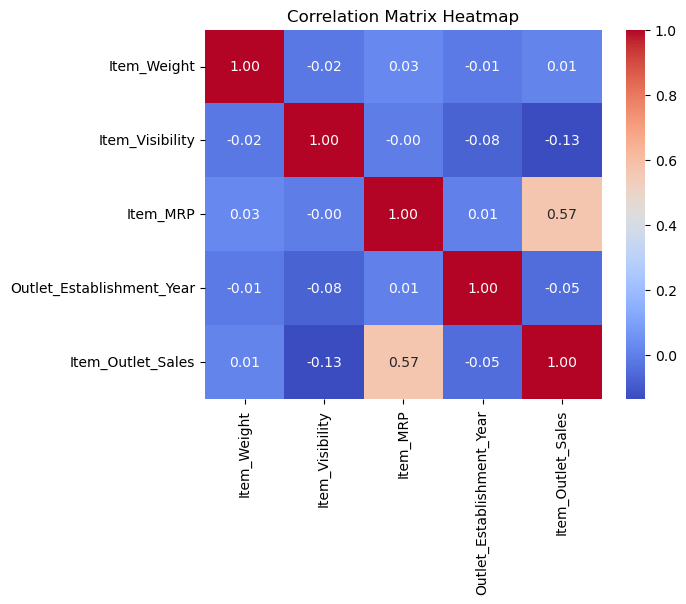

In [38]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()

## EDA & Feature Engineering ##

In [39]:
# Check for duplicates, if present
print(df2.shape)
df2.drop_duplicates(subset=None,keep='first',inplace=True,ignore_index=False)
print(df2.shape)

(8523, 12)
(8523, 12)


In [120]:
df2_xtra = df2.copy()

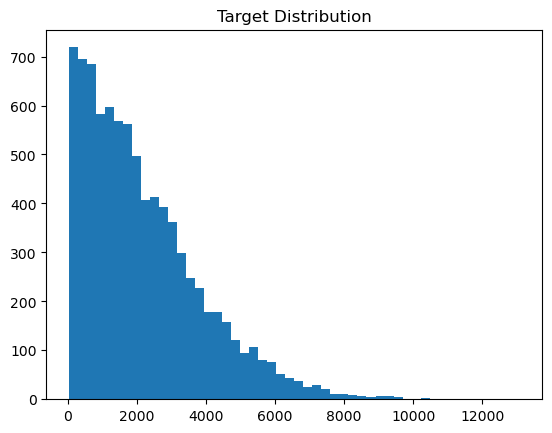

In [121]:
plt.hist(df2_xtra['Item_Outlet_Sales'], bins=50)
plt.title('Target Distribution')
plt.show()

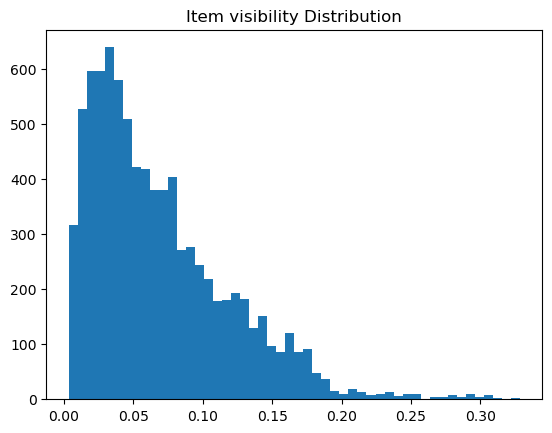

In [122]:
plt.hist(df2_xtra['Item_Visibility'], bins=50)
plt.title('Item visibility Distribution')
plt.show()

Upper limit:  0.196003129
Lower limit:  -0.069001475


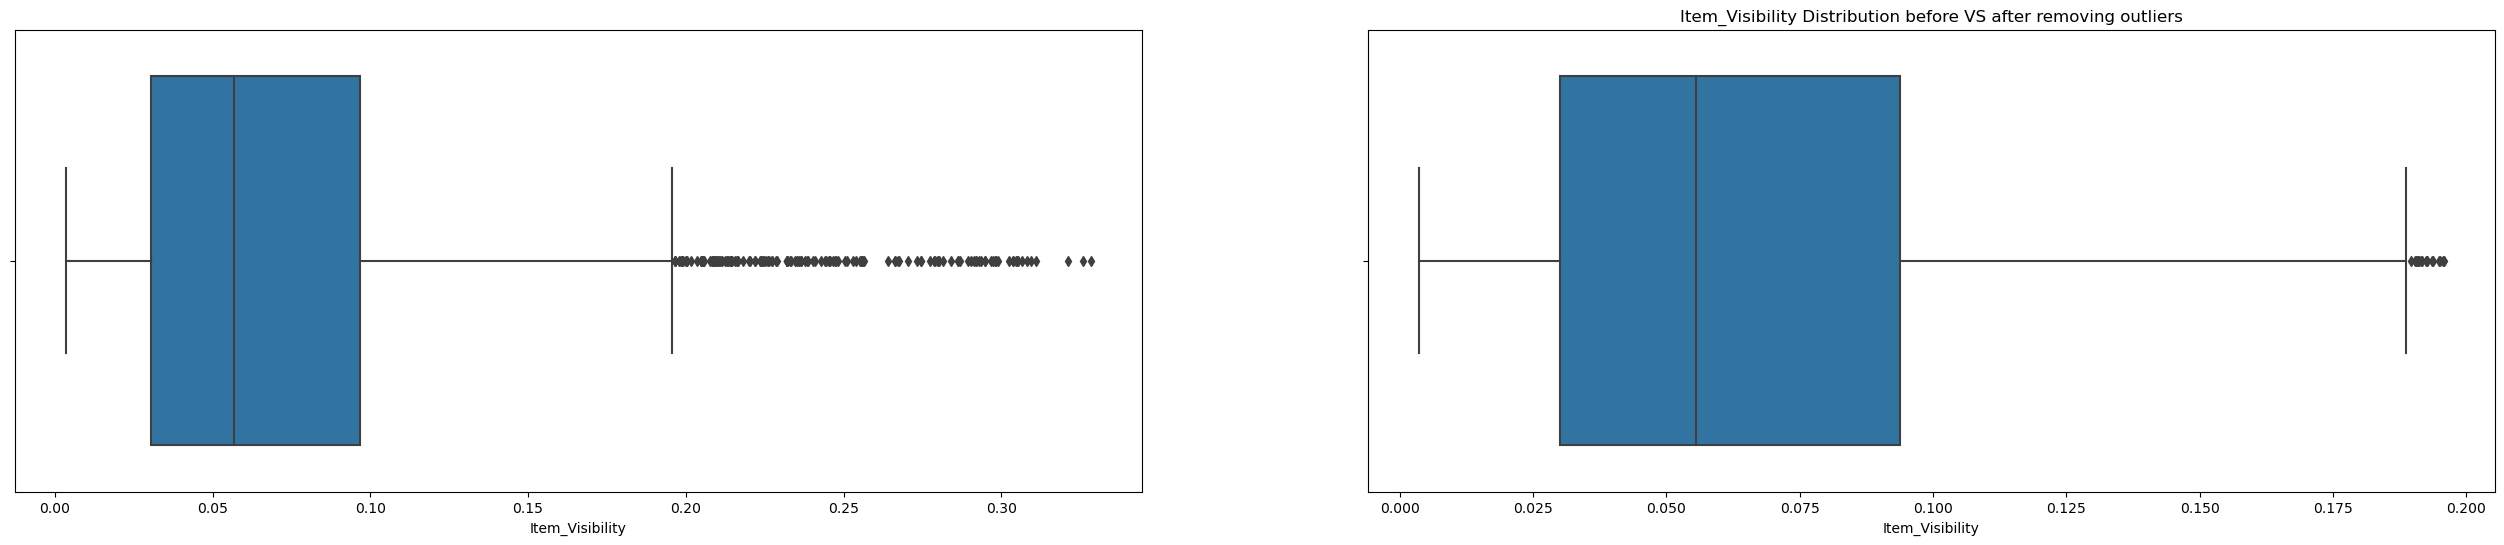

In [123]:
## As the above histograms show both item sales and item visibility are heavily right skewed with presence of outliers below 
## function is created to treat outliers.

def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(df2_xtra, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=df2_xtra['Item_Visibility'], ax=ax[0])

# removing outliers using the above function
df2_xtra = df2_xtra[(df2_xtra['Item_Visibility'] > lower) & (df2_xtra['Item_Visibility'] < upper)]

sns.boxplot(x=df2_xtra['Item_Visibility'], ax=ax[1])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6496.2106
Lower limit:  -2494.7526000000003


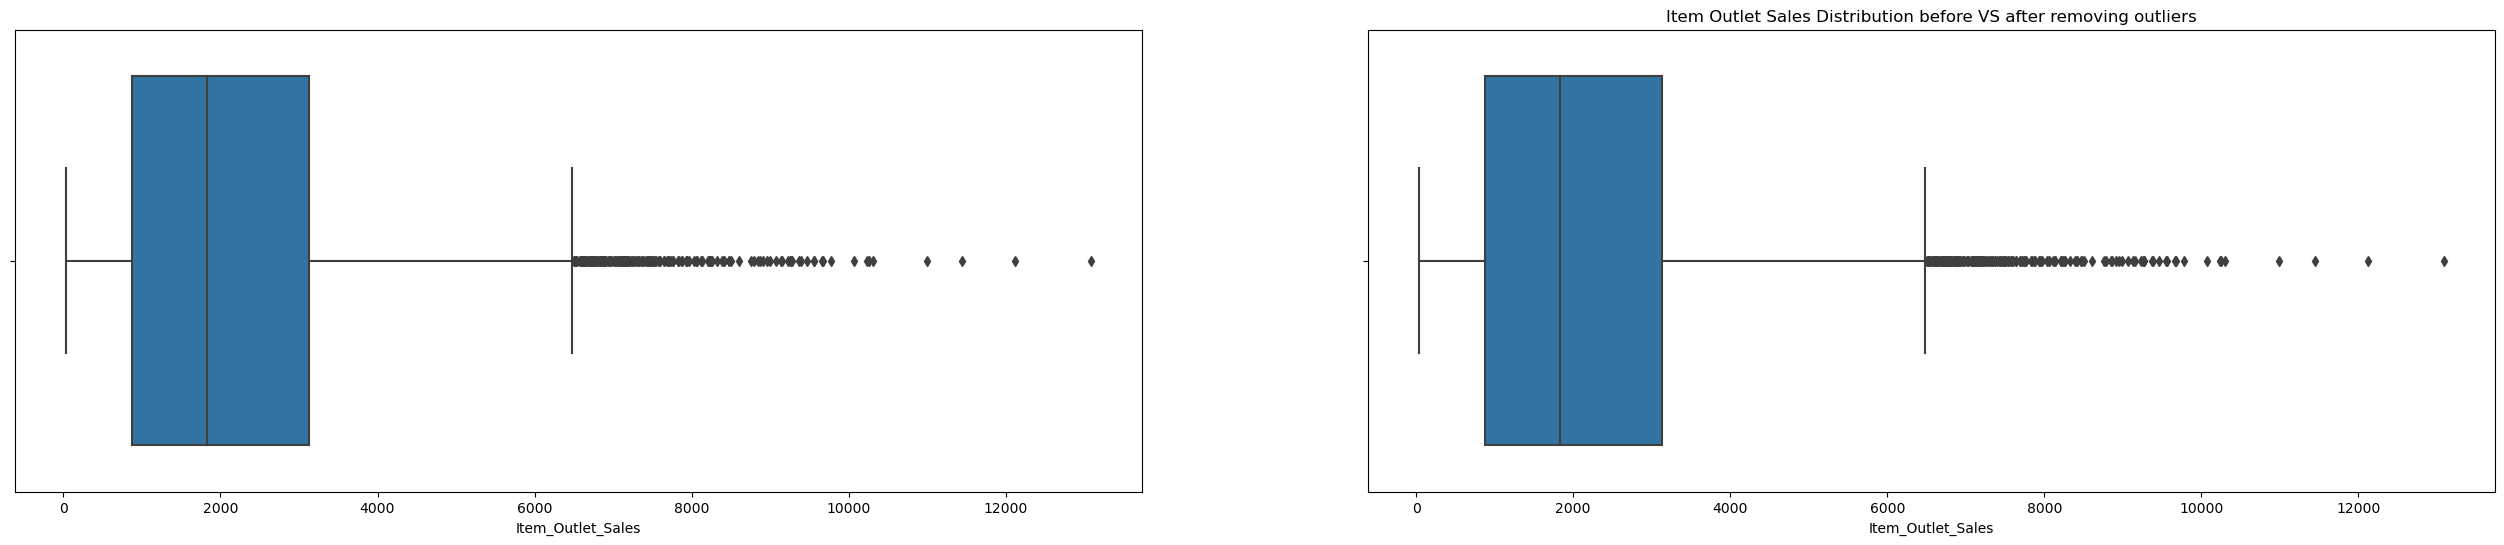

In [124]:
# detect outliers in the Item_Outlet_Sales feature
upper, lower = detect_outliers(df2_xtra, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=df2_xtra['Item_Outlet_Sales'], ax=ax[0])

# removing outliers using the same function
train = df2_xtra[(df2_xtra['Item_Outlet_Sales'] > lower) & (df2_xtra['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=df2_xtra['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

In [125]:
df2_xtra[df2_xtra['Outlet_Identifier'].isin(['OUT010','OUT019'])]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.200,Regular,0.024815,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
23,FDC37,15.500,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
28,FDE51,5.925,Regular,0.161467,Dairy,45.5086,OUT010,1998,Small,Tier 3,Grocery Store,178.4344
29,FDC14,14.500,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
30,FDV38,19.250,Low Fat,0.170349,Dairy,55.7956,OUT010,1998,Small,Tier 3,Grocery Store,163.7868
...,...,...,...,...,...,...,...,...,...,...,...,...
8469,FDQ45,9.500,Regular,0.019114,Snack Foods,182.1608,OUT019,1985,Small,Tier 1,Grocery Store,367.5216
8473,DRI47,14.700,Low Fat,0.035016,Hard Drinks,144.3128,OUT010,1998,Small,Tier 3,Grocery Store,431.4384
8480,FDQ58,7.315,Low Fat,0.019114,Snack Foods,154.5340,OUT019,1985,Small,Tier 1,Grocery Store,459.4020
8486,FDR20,20.000,Regular,0.024815,Fruits and Vegetables,46.4744,OUT010,1998,Small,Tier 3,Grocery Store,45.2744


In [45]:
#Since 2013 is the year of reference, no. of operational years can be calculated:
df2_xtra['op_yrs'] = [(2013-i) for i in df2_xtra['Outlet_Establishment_Year']]
df2_xtra.head()           

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,op_yrs
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14
3,FDX07,19.20,Regular,0.024815,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,15
4,NCD19,8.93,Low Fat,0.072655,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26


In [46]:
for i in df2_xtra[['Item_Fat_Content','Item_Type']].columns:
    print (i , '\n', df2_xtra[i].value_counts(), '\n')

Item_Fat_Content 
 Low Fat    5428
Regular    2946
Name: Item_Fat_Content, dtype: int64 

Item_Type 
 Fruits and Vegetables    1208
Snack Foods              1180
Household                 897
Frozen Foods              845
Dairy                     667
Canned                    638
Baking Goods              631
Health and Hygiene        515
Soft Drinks               439
Meat                      418
Breads                    248
Hard Drinks               211
Others                    167
Starchy Foods             143
Breakfast                 106
Seafood                    61
Name: Item_Type, dtype: int64 



In [47]:
#Create item_category
df2_xtra['item_category'] = df2_xtra['Item_Identifier'].str[:2]
df2_xtra['item_category'] = df2_xtra['item_category'].map({'FD':'food','DR':'drinks','NC':'non_consumable'})

#df2_xtra.loc[df2_xtra['item_category']=='non_consumable','Item_Fat_Content'] == 'non_edible'
df2_xtra.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,op_yrs,item_category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14,food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4,drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14,food
3,FDX07,19.20,Regular,0.024815,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,15,food
4,NCD19,8.93,Low Fat,0.072655,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26,non_consumable


In [48]:
df2_xtra.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,op_yrs,item_category
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14,food
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,4,drinks
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14,food
3,FDX07,19.20,Regular,0.024815,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,15,food
4,NCD19,8.93,Low Fat,0.072655,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,26,non_consumable


## Label Encoding ##

In [49]:
# Qualitative Data
df2_xtra_enc = df2_xtra.copy()
le = LabelEncoder()

cols_to_le = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type'
              ] #'item_category'

for col in cols_to_le:
    df2_xtra_enc[col] = le.fit_transform(df2_xtra_enc[col])

df2_xtra_enc.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,op_yrs,item_category
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,1999,1,0,1,3735.1380,14,food
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2009,1,2,2,443.4228,4,drinks
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,1999,1,0,1,2097.2700,14,food
3,FDX07,19.20,1,0.024815,Fruits and Vegetables,182.0950,OUT010,1998,2,2,0,732.3800,15,food
4,NCD19,8.93,0,0.072655,Household,53.8614,OUT013,1987,0,2,1,994.7052,26,non_consumable


In [50]:
df2_xtra_enc.shape

(8374, 14)

In [51]:
df2_xtra.head(10)
df2_xtra.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
op_yrs                       0
item_category                0
dtype: int64

## One Hot Encoding ##

In [52]:
df2_dummy = pd.get_dummies(df2_xtra_enc,columns=['item_category','Item_Type','Outlet_Identifier'],drop_first=True)
df2_dummy.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDA15,9.30,0,0.016047,249.8092,1999,1,0,1,3735.1380,...,0,0,0,0,0,0,0,0,0,1
1,DRC01,5.92,1,0.019278,48.2692,2009,1,2,2,443.4228,...,0,0,0,1,0,0,0,0,0,0
2,FDN15,17.50,0,0.016760,141.6180,1999,1,0,1,2097.2700,...,0,0,0,0,0,0,0,0,0,1
3,FDX07,19.20,1,0.024815,182.0950,1998,2,2,0,732.3800,...,0,0,0,0,0,0,0,0,0,0
4,NCD19,8.93,0,0.072655,53.8614,1987,0,2,1,994.7052,...,0,1,0,0,0,0,0,0,0,0


In [53]:
df2_dummy.shape

(8374, 37)

In [54]:
df2_dummy.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_MRP', 'Outlet_Establishment_Year', 'Outlet_Size',
       'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales', 'op_yrs',
       'item_category_food', 'item_category_non_consumable',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049'],
      dtype='object')

In [116]:
df2_dummy[df2_dummy['Item_Outlet_Sales']<=0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,...,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049


## Train Test Split ##

In [126]:
x = df2_dummy.drop(['Item_Outlet_Sales','Outlet_Establishment_Year',#,'Outlet_Location_Type',
                     'Item_Identifier'],axis=1)
#x['Item_MRP'] = np.log1p(x['Item_MRP'])
#y = df2_dummy['Item_Outlet_Sales']
y = df2_dummy['Item_Outlet_Sales']
#y = df2_xtra['Item_Outlet_Sales']
#y = np.log1p(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.20,random_state=42)

In [127]:
x_train.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,op_yrs,item_category_food,item_category_non_consumable,...,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
5810,19.00,1,0.097295,47.7718,2,1,1,9,1,0,...,0,0,0,0,0,0,1,0,0,0
7148,12.50,1,0.024815,80.8592,2,2,0,15,1,0,...,0,0,0,0,0,0,0,0,0,0
673,19.70,0,0.053524,55.3930,2,1,1,6,1,0,...,0,0,1,0,0,0,0,0,0,0
7627,15.70,1,0.037865,124.1046,2,0,1,16,1,0,...,0,0,0,0,0,0,0,0,1,0
8157,14.35,0,0.080204,77.9960,1,2,3,28,1,0,...,0,0,0,0,0,1,0,0,0,0


## Linear Regression ##

In [59]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(x_train, y_train)

LinearRegression()

In [60]:
# Predictions for LinearRegression on the test data
lin_reg_predictions = lin_reg_model.predict(x_test)

In [61]:
print('Training score  : {}'.format(lin_reg_model.score(x_train, y_train)))
print('Test score      : {}'.format(lin_reg_model.score(x_test, y_test)))

Training score  : 0.5555868405386999
Test score      : 0.5717399110388326


In [62]:
# Evaluation
import math
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE: {}'.format(lin_reg_rmse))
print('R2 Score: {}'.format(lin_reg_r2))

RMSE: 1087.7066786772016
R2 Score: 0.5717399110388326


## Non Linear regression ##

In [63]:
steps = [
    ('scaler', StandardScaler()),
    ('poly',   PolynomialFeatures(degree=2)),
    ('model',  LinearRegression())
       ]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(x_train, y_train)

print('Training score  : {}'.format(lin_reg_pipeline.score(x_train, y_train)))
print('Test score      : {}'.format(lin_reg_pipeline.score(x_test, y_test)))

Training score  : 0.6107750701562054
Test score      : 0.5955715575008006


In [64]:
lin_reg_predictions = lin_reg_pipeline.predict(x_test)

In [65]:
# Evaluation (Polynomial beyond degree of 2 doesn't yield better result)
import math
lin_reg_mse  = mean_squared_error(y_test , lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2   = r2_score(y_test, lin_reg_predictions)

print('RMSE: {}'.format(lin_reg_rmse))
print('R2 Score: {}'.format(lin_reg_r2))

RMSE: 1057.0093748627478
R2 Score: 0.5955715575008006


## Ridge Regression L2 ##

In [66]:
steps = [
            ('scaler', StandardScaler()),
            ('poly'  , PolynomialFeatures(degree=2)),
            ('model' , Ridge(alpha=7, fit_intercept=True))
       ]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(x_train, y_train)

print('Training Score: {}'.format(ridge_pipeline.score(x_train, y_train)))
print('Test Score: {}'.format(ridge_pipeline.score(x_test, y_test)))

Training Score: 0.610773562396547
Test Score: 0.5956969163652367


In [67]:
ridge_predictions = ridge_pipeline.predict(x_test)

In [68]:
# Evaluation
ridge_mse  = mean_squared_error(y_test , ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2   = r2_score(y_test, ridge_predictions)

print('Ridge RMSE {}'.format(ridge_rmse))
print('Ridge R2 Score {}'.format(ridge_r2))

Ridge RMSE 1056.8455439465333
Ridge R2 Score 0.5956969163652367


## Lasso Regression L1 ##

In [69]:
steps = [
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2)),
            ('model', Lasso(alpha=0.2, fit_intercept=True))
        ]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(x_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(x_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(x_test, y_test)))

Training score  : 0.610751784693788
Test score      : 0.5962754090037912


In [70]:
lasso_predictions = lasso_pipeline.predict(x_test)

In [71]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE {}'.format(lasso_rmse))
print('Lasso R2 Score {}'.format(lasso_r2))

Lasso RMSE 1056.0891853578041
Lasso R2 Score 0.5962754090037912


## Random Forest ##

In [72]:
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=21, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=15, n_jobs=-1, random_state=21)

In [73]:
y_pred = rf.predict(x_test)

In [74]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f'R² Score: {r2:.4f}')

RMSE: 1078.48
MAPE: 55.02%
R² Score: 0.5790


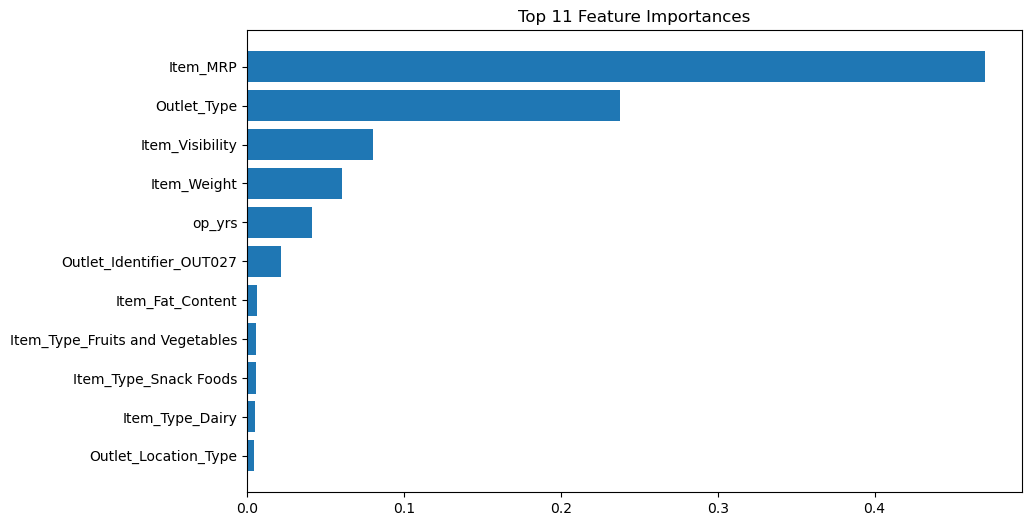

In [75]:
importances = rf.feature_importances_
features = x.columns

sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Top 11 Feature Importances")
plt.barh(range(11), importances[sorted_idx][:11], align="center")
plt.yticks(range(11), [features[i] for i in sorted_idx[:11]])
plt.gca().invert_yaxis()
plt.show()

## XG Boost ##

In [128]:
import xgboost as xgb

In [129]:
# Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 5, 
#                   'n_estimators': 1000, 'subsample': 0.8}
#                  Best RMSE (negative): -0.5237156527747098


# Define model
xgb_model = xgb.XGBRegressor(objective='reg:tweedie', tweedie_variance_power=1.5,
    n_estimators=1000,
    learning_rate=0.05,
    gamma=0.2,
    max_depth=4,
    min_child_weight =3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=21,
    n_jobs=-1
)

# Fit model
xgb_model.fit(x_train, y_train, early_stopping_rounds=20, eval_set=[(x_test, y_test)], verbose=False)

# Predict
y_pred = xgb_model.predict(x_test)

In [130]:
# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred) * 100
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f'R² Score: {r2:.4f}')

RMSE: 1040.21
MAPE: 52.52%
R² Score: 0.6083


In [132]:
sum(y_pred<=0)

0

## XGBoost has performed better amongst all and hence has been the chosen model for test data predictions ##

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

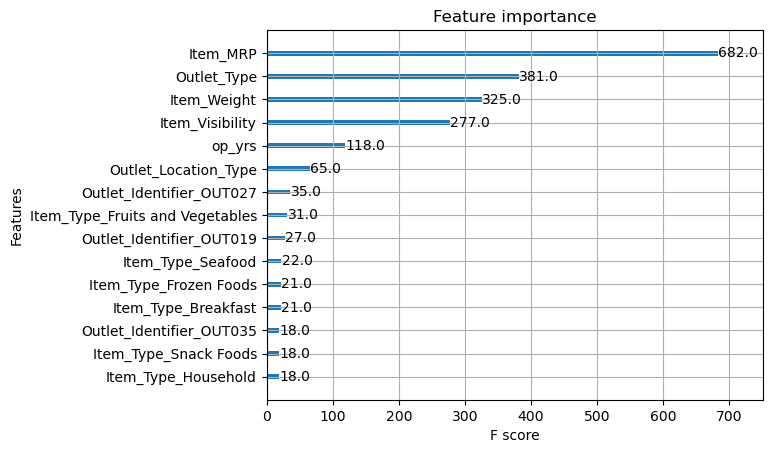

In [131]:
xgb.plot_importance(xgb_model, max_num_features=15)

## Test Dataset (test_AbJTz2l) Prediction ##

In [133]:
df_test = pd.read_csv('test_AbJTz2l.csv')
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [134]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


In [135]:
df_test.isnull().sum()

Item_Identifier                 0
Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [136]:
# Imputing missing values in Item_Weight
df_test['Item_Weight'] = df_test['Item_Weight'].fillna(df_test.groupby('Item_Identifier')['Item_Weight'].transform('mean'))
df_test.isnull().sum()

Item_Identifier                 0
Item_Weight                    20
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [137]:
df_test = impute_weight_traits(df_test,weight='Item_Weight',traits=['Item_Fat_Content','Item_Type'])
df_test.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [138]:
## Imputing missing values in Outlet_Size
df_test = impute_size_traits(df_test,size='Outlet_Size',traits=['Outlet_Location_Type','Outlet_Type'])
df_test.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64

In [139]:
df_test['Outlet_Size'].apply(type).value_counts()

<class 'str'>              5311
<class 'numpy.ndarray'>     370
Name: Outlet_Size, dtype: int64

In [140]:
## Assumin LF, low fat stands for Low Fat and reg stands for Regular
df_test['Item_Fat_Content'] = ['Regular' if 'reg' in i else i for i in df_test['Item_Fat_Content']]
df_test['Item_Fat_Content'] = ['Low Fat' if 'LF' in i or 'low' in i else i for i in df_test['Item_Fat_Content']]

In [141]:
df_test['Outlet_Size'] = df_test['Outlet_Size'].apply(lambda x:np.nan if isinstance(x,np.ndarray) and x.size==0 else x)

In [142]:
df_test['Outlet_Size'].apply(type).value_counts()

<class 'str'>      5311
<class 'float'>     370
Name: Outlet_Size, dtype: int64

In [143]:
for i in df_test[df_test['Outlet_Size'].isnull()][['Outlet_Establishment_Year','Outlet_Location_Type','Outlet_Type']].columns:
    print (i, '\n', df_test[df_test['Outlet_Size'].isnull()][i].value_counts(), '\n')

Outlet_Establishment_Year 
 1998    370
Name: Outlet_Establishment_Year, dtype: int64 

Outlet_Location_Type 
 Tier 3    370
Name: Outlet_Location_Type, dtype: int64 

Outlet_Type 
 Grocery Store    370
Name: Outlet_Type, dtype: int64 



In [144]:
#Using the same analysis as that in training data, Outlet_Size is to be replaced with 'Small'
df_test['Outlet_Size'] = df_test['Outlet_Size'].replace(np.nan,'Small')
df_test[df_test['Outlet_Size'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type


In [145]:
df_test[df_test['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
56,FDA09,13.350,Regular,0.0,Snack Foods,179.6660,OUT013,1987,High,Tier 3,Supermarket Type1
90,FDN39,19.350,Regular,0.0,Meat,165.7816,OUT045,2002,Small,Tier 2,Supermarket Type1
109,FDU14,17.750,Low Fat,0.0,Dairy,249.7750,OUT018,2009,Medium,Tier 3,Supermarket Type2
125,FDZ36,6.035,Regular,0.0,Baking Goods,186.4240,OUT027,1985,Medium,Tier 3,Supermarket Type3
140,DRF48,5.730,Low Fat,0.0,Soft Drinks,188.3898,OUT010,1998,Small,Tier 3,Grocery Store
...,...,...,...,...,...,...,...,...,...,...,...
5643,FDQ19,7.350,Regular,0.0,Fruits and Vegetables,244.3512,OUT019,1985,Small,Tier 1,Grocery Store
5648,FDK26,5.460,Regular,0.0,Canned,187.5240,OUT027,1985,Medium,Tier 3,Supermarket Type3
5654,FDQ57,7.275,Low Fat,0.0,Snack Foods,144.5760,OUT013,1987,High,Tier 3,Supermarket Type1
5661,DRG37,16.200,Low Fat,0.0,Soft Drinks,155.7972,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [146]:
# Impute Item_Visibility of 0s with non zero values
df_test = impute_visibility_traits(df_test,visibility='Item_Visibility',traits=['Item_Identifier','Outlet_Type','Outlet_Size','Item_Type'])

In [147]:
df_test['Item_Visibility'].apply(type).value_counts()

<class 'float'>    5681
Name: Item_Visibility, dtype: int64

In [148]:
df_test[df_test['Item_Visibility'].isnull()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
56,FDA09,13.350,Regular,NaN,Snack Foods,179.6660,OUT013,1987,High,Tier 3,Supermarket Type1
90,FDN39,19.350,Regular,NaN,Meat,165.7816,OUT045,2002,Small,Tier 2,Supermarket Type1
109,FDU14,17.750,Low Fat,NaN,Dairy,249.7750,OUT018,2009,Medium,Tier 3,Supermarket Type2
125,FDZ36,6.035,Regular,NaN,Baking Goods,186.4240,OUT027,1985,Medium,Tier 3,Supermarket Type3
140,DRF48,5.730,Low Fat,NaN,Soft Drinks,188.3898,OUT010,1998,Small,Tier 3,Grocery Store
...,...,...,...,...,...,...,...,...,...,...,...
5643,FDQ19,7.350,Regular,NaN,Fruits and Vegetables,244.3512,OUT019,1985,Small,Tier 1,Grocery Store
5648,FDK26,5.460,Regular,NaN,Canned,187.5240,OUT027,1985,Medium,Tier 3,Supermarket Type3
5654,FDQ57,7.275,Low Fat,NaN,Snack Foods,144.5760,OUT013,1987,High,Tier 3,Supermarket Type1
5661,DRG37,16.200,Low Fat,NaN,Soft Drinks,155.7972,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [149]:
df_test = impute_visibility_traits(df_test,visibility='Item_Visibility',traits=['Item_Type','Outlet_Type'])

In [150]:
df_test[df_test['Item_Visibility']==0]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type


In [151]:
# Check for duplicates, if present
print(df_test.shape)
df_test.drop_duplicates(subset=None,keep='first',inplace=True,ignore_index=False)
print(df_test.shape)

(5681, 11)
(5681, 11)


## Feature Engineering ##

In [152]:
#Since 2013 is the year of reference, no. of operational years can be calculated:
df_test['op_yrs'] = [(2013-i) for i in df_test['Outlet_Establishment_Year']]
df_test.head() 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,op_yrs
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,14
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,6
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,15
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,6
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,28


In [153]:
#Create item_category
df_test['item_category'] = df_test['Item_Identifier'].str[:2]
df_test['item_category'] = df_test['item_category'].map({'FD':'food','DR':'drinks','NC':'non_consumable'})

#df_test.loc[df_test['item_category']=='non_consumable','Item_Fat_Content'] == 'non_edible'
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,op_yrs,item_category
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,14,food
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,6,food
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,15,non_consumable
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,6,food
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,28,food


In [154]:
df_test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,op_yrs,item_category
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1,14,food
1,FDW14,8.300,Regular,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1,6,food
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,Small,Tier 3,Grocery Store,15,non_consumable
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1,6,food
4,FDY38,13.600,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3,28,food


In [155]:
#Label encoding
# Qualitative Data
df_test_enc = df_test.copy()

le = LabelEncoder()

cols_to_le = ['Item_Fat_Content','Outlet_Size','Outlet_Location_Type','Outlet_Type'
              ] 

for col in cols_to_le:
    df_test_enc[col] = le.fit_transform(df_test_enc[col])

df_test_enc.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,op_yrs,item_category
0,FDW58,20.750,0,0.007565,Snack Foods,107.8622,OUT049,1999,1,0,1,14,food
1,FDW14,8.300,1,0.038428,Dairy,87.3198,OUT017,2007,2,1,1,6,food
2,NCN55,14.600,0,0.099575,Others,241.7538,OUT010,1998,2,2,0,15,non_consumable
3,FDQ58,7.315,0,0.015388,Snack Foods,155.0340,OUT017,2007,2,1,1,6,food
4,FDY38,13.600,1,0.118599,Dairy,234.2300,OUT027,1985,1,2,3,28,food


In [156]:
#OHE
df_test_dummy = pd.get_dummies(df_test_enc,columns=['item_category','Item_Type','Outlet_Identifier'],drop_first=True)
df_test_dummy.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,op_yrs,...,Item_Type_Starchy Foods,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,FDW58,20.750,0,0.007565,107.8622,1999,1,0,1,14,...,0,0,0,0,0,0,0,0,0,1
1,FDW14,8.300,1,0.038428,87.3198,2007,2,1,1,6,...,0,0,1,0,0,0,0,0,0,0
2,NCN55,14.600,0,0.099575,241.7538,1998,2,2,0,15,...,0,0,0,0,0,0,0,0,0,0
3,FDQ58,7.315,0,0.015388,155.0340,2007,2,1,1,6,...,0,0,1,0,0,0,0,0,0,0
4,FDY38,13.600,1,0.118599,234.2300,1985,1,2,3,28,...,0,0,0,0,0,1,0,0,0,0


In [157]:
test_real = df_test_dummy.drop(['Outlet_Establishment_Year','Item_Identifier'],axis=1)

test_real.columns

Index(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'op_yrs',
       'item_category_food', 'item_category_non_consumable',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT019',
       'Outlet_Identifier_OUT027', 'Outlet_Identifier_OUT035',
       'Outlet_Identifier_OUT045', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT049'],
      dtype='object')

In [158]:
test_real.shape

(5681, 34)

In [159]:
x_train.shape

(6699, 34)

In [160]:
# Predict
test_pred = xgb_model.predict(test_real)

In [161]:
df_test['Item_Outlet_Sales'] = test_pred
df_test = df_test[['Item_Identifier','Outlet_Identifier','Item_Outlet_Sales']]
df_test.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1587.296753
1,FDW14,OUT017,1377.920898
2,NCN55,OUT010,656.594238
3,FDQ58,OUT017,2443.635986
4,FDY38,OUT027,5812.924316


In [163]:
df_test.to_csv('BigMart_Sales_prediction_v2.csv',index=False)